# Get started with circuit cutting

This guide demonstrates a few simple working examples to get started with the `qiskit-addon-cutting` package. These examples will cover reconstructing expectation values of a seven-qubit circuit using wire cutting and reducing circuit depth and width using gate cutting.

## Wire cutting

To demonstrate expectation value reconstruction after wire cutting, first create a circuit with several non-local gates and define observables to estimate.

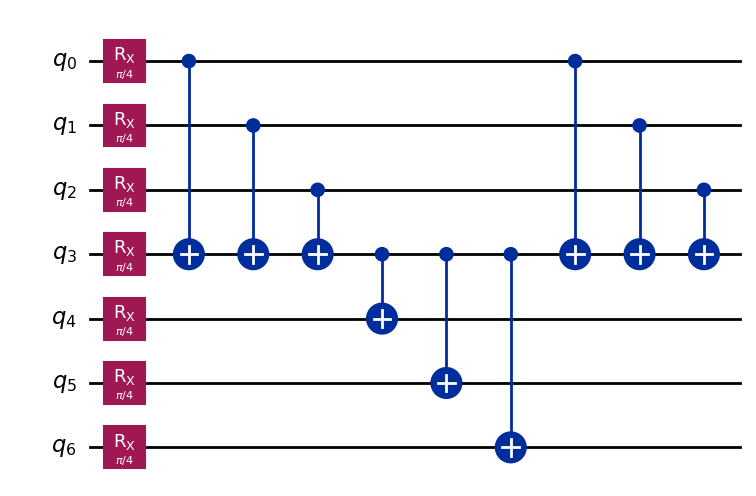

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_cutting.instructions import Move
from qiskit_addon_cutting import partition_problem

qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

# Define observables
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

# Draw circuit
qc_0.draw("mpl")

In this circuit, a wire cut can be made at qubit $q_3$ which, in the `qiskit-addon-cutting` package is represented by a [`Move`](../api/qiskit-addon-cutting/instructions-move) instruction. This gate is defined as a reset of the second qubit followed by a swap of both qubits, which has the effect of transferring the state of the first qubit wire into the second, while simultaneously discarding the state of the second qubit wire.

We can manually place these `Move` instructions in a new circuit, but for this to work properly, it is important that the second (destination) qubit share no entanglement with the remainder of the system; otherwise, the reset operation will cause the state of the remainder to partially collapse. In order to avoid this in this example, we will include a second `Move` instruction which is reversed.

When adding in the `Move` instructions, a new observable should be included to account for the extra qubit wire that was added. This can be done by including an extra $I$ at index $4$.

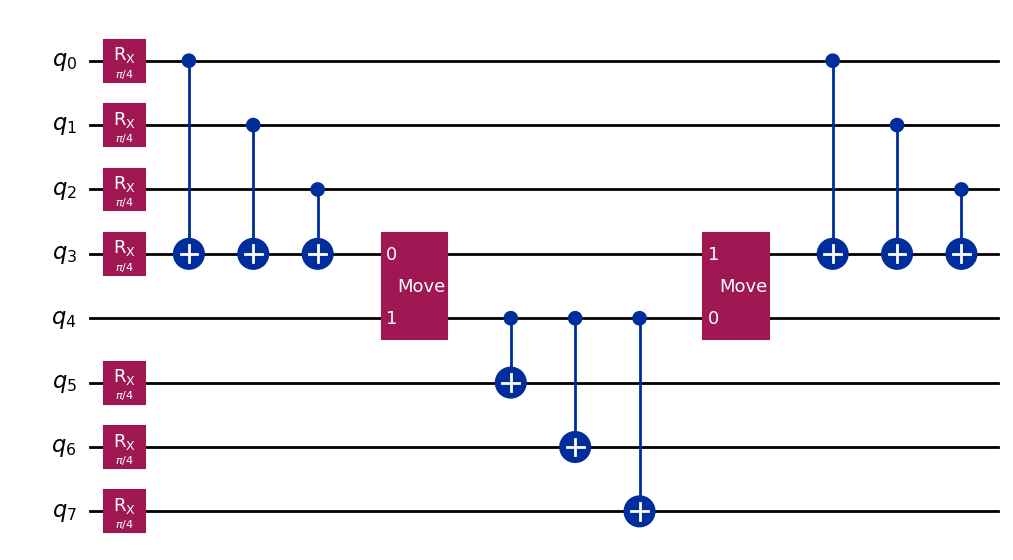

In [6]:
qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

qc_1.draw("mpl")

<Admonition type="information" title="Note"> 
    As an alternative to working directly with [`Move`](../api/qiskit-addon-cutting/instructions-move) instructions, you may choose to mark wire cuts using a single-qubit [`CutWire`](../api/qiskit-addon-cutting/instructions-cut-wire) instruction. Once the subexperiments are prepared to be executed, use the [`cut_wires`](../api/qiskit-addon-cutting/qiskit-addon-cutting#cut_wires) method to transform `CutWire` to `Move` instructions on newly allocated qubits. However, in contrast to the manual method, this automatic method does not allow for re-use of qubit wires.
</Admonition>

### Separate the circuit and observable

Now that the circuit includes `Move` instructions to represent wire cuts, the problem can be separated into partitions. This is accomplished using the [`partition_problem`](../api/qiskit-addon-cutting/qiskit-addon-cutting#partition_problem) method with a set of partition labels to specify how the circuit is separated. Qubits sharing a common partition label will be grouped together, and any non-local gates spanning more than one partition will be cut.

In this partitioning scheme, we will have cut two wires, which results in a sampling overhead of $4^4$.


Subobservables to measure: 
{'A': PauliList(['IIII', 'ZIII', 'IIIZ']), 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


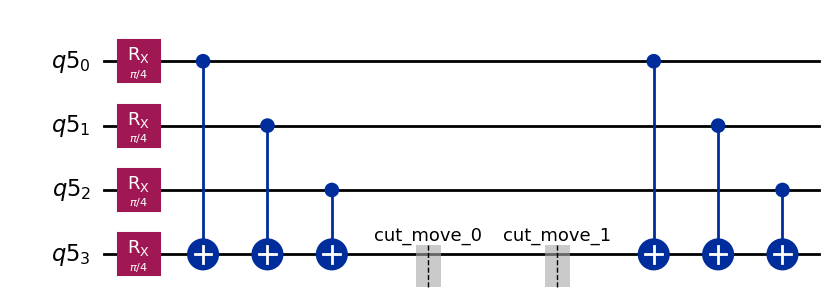

In [10]:
partitioned_problem = partition_problem(
    circuit=qc_1, partition_labels="AAAABBBB", observables=observable_expanded.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

print(f'Subobservables to measure: \n{subobservables}\n')
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits["A"].draw("mpl")

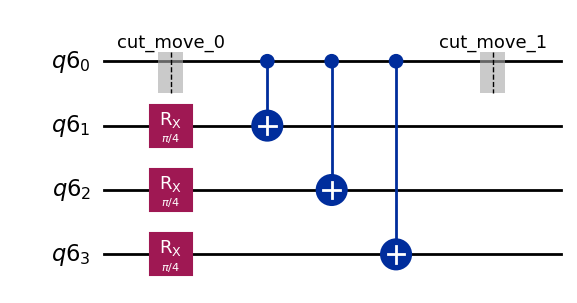

In [11]:
subcircuits["B"].draw("mpl")

###